# Cluster Analysis of BostonBlueBikes

In [1]:
import numpy as np
import pandas as pd
import folium
from math import sin, cos, pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from folium import plugins

## Load processed dataframe

In [2]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': np.int64, 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_municipality,end_station_municipality,date_time
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,Cambridge,Cambridge,2015-01-01 00:00:00
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,Cambridge,Cambridge,2015-01-01 00:00:00
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,Cambridge,Cambridge,2015-01-01 01:00:00
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,Cambridge,Cambridge,2015-01-01 01:00:00
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427,Cambridge,Cambridge,2015-01-01 01:00:00


## Clustering of trip types

### Data Preparation

##### To cluster different types of trips, we prepare a dataframe that includes time of rental (daytime and weekday) and duration. We develop clusters for the complete dataframe as well as for the two user types (Subscriber or Customer), respectively. 

In [3]:
#define dataframe with important features and define features of weekday and hour of day
features  = ['start_time', 'start_station_id', 'trip_length', 'user_type']
trip_types = df_boston[features].copy()
trip_types.loc[:,'hour'] = trip_types['start_time'].apply( lambda x: x.hour + (x.minute/60))
trip_types.loc[:, 'weekday'] = trip_types['start_time'].apply(lambda x: x.day_of_week)
trip_types.loc[:, 'month'] = trip_types['start_time'].apply(lambda x: x.month)
trip_types.loc[:, 'season'] = trip_types['start_time'].apply(lambda x: x.month%12//3 +1) 

#rename and define duration
trip_types['trip_length'] = trip_types['trip_length'].apply(lambda x: x/3600)
trip_types = trip_types.rename(columns = {'trip_length' : 'duration_in_hours'})
trip_types.head()

,start_time,start_station_id,duration_in_hours,user_type,hour,weekday,month,season
0,2015-01-01 00:21:44,115,0.150833,Subscriber,0.350000,3,1,1
1,2015-01-01 00:27:03,80,0.121667,Subscriber,0.450000,3,1,1
2,2015-01-01 00:31:31,91,0.070833,Subscriber,0.516667,3,1,1
3,2015-01-01 00:53:46,115,0.120000,Subscriber,0.883333,3,1,1
4,2015-01-01 01:07:06,105,0.204167,Customer,1.116667,3,1,1


In [5]:
#hour and weekday need to be recalculated as circular features in order to ensure the correct distances between each hour/day
def circular( dataframe, feature, name, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular(trip_types, trip_types["hour"], "hour", 24)
circular(trip_types, trip_types['weekday'], "weekday", 7)

#define dataframe for subsribers and customers only
trip_types_subs = trip_types.loc[trip_types['user_type'] == 'Subscriber']
trip_types_cus = trip_types.loc[trip_types['user_type'] == 'Customer']

#drop features that need not or cannot to be scaled
X = trip_types.drop(['hour', 'weekday', 'start_time', 'start_station_id',  'user_type', 'month', 'season'], axis = 1)
X_s = trip_types_subs.drop(['hour', 'weekday', 'start_time', 'start_station_id', 'user_type', 'month', 'season'], axis = 1)
X_c = trip_types_cus.drop(['hour', 'weekday', 'start_time', 'start_station_id', 'user_type', 'month', 'season'], axis = 1)


In [6]:
X.head()

,duration_in_hours,hour_sin,hour_cos,weekday_sin,weekday_cos
0,0.150833,0.091502,0.995805,0.433884,-0.900969
1,0.121667,0.117537,0.993068,0.433884,-0.900969
2,0.070833,0.134851,0.990866,0.433884,-0.900969
3,0.120000,0.229200,0.973379,0.433884,-0.900969
4,0.204167,0.288196,0.957571,0.433884,-0.900969


##### Scaling variables to ensure that certain columns are not valued more due to generally higher values

In [7]:
scaler= StandardScaler()

def scaling(data):
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    data_scaled_df = pd.DataFrame(data_scaled, columns = data.columns, index = data.index)
    return data_scaled, data_scaled_df

X_scaled, X_scaled_df = scaling(X)
X_scaled_s, X_scaled_df_s = scaling(X_s)
X_scaled_c, X_scaled_df_c = scaling(X_c)

# s = subscriber, c = customer


In [8]:
#rename to ensure better understanding of dataframes
trip_types_scaled = X_scaled_df
trip_types_scaled_s = X_scaled_df_s
trip_types_scaled_c = X_scaled_df_c

trip_types_scaled.head()

,duration_in_hours,hour_sin,hour_cos,weekday_sin,weekday_cos
0,-0.454400,0.525140,2.320551,0.513724,-1.19091
1,-0.634449,0.561671,2.315686,0.513724,-1.19091
2,-0.948249,0.585964,2.311770,0.513724,-1.19091
3,-0.644737,0.718347,2.280681,0.513724,-1.19091
4,-0.125166,0.801126,2.252576,0.513724,-1.19091


### Choose number of clusters to use
For this we decided to use the residual loss selection criteria to identify the range of clusters to produce good and reasonable results.  

In [9]:
#calculate optimal range of amount of clusters to use 

def k_optimal(data, k_max):
    clusters = []
    losses = []
    for k in range(k_max):
        model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
        model.fit(data)
        clusters.append(k+1)
        losses.append(model.inertia_)
    plt.plot(clusters, losses)
        #plt.xlim([2,10])
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()


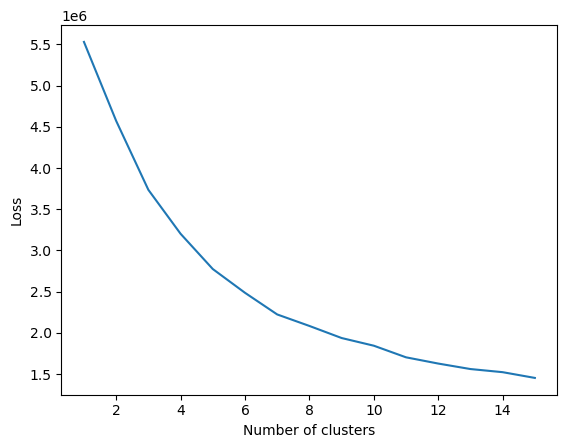

In [10]:
k_optimal(X_scaled, 15)

For the complete dataframe there seems to be an optimal number of 6-8 clusters. We chose 7 clusters. 

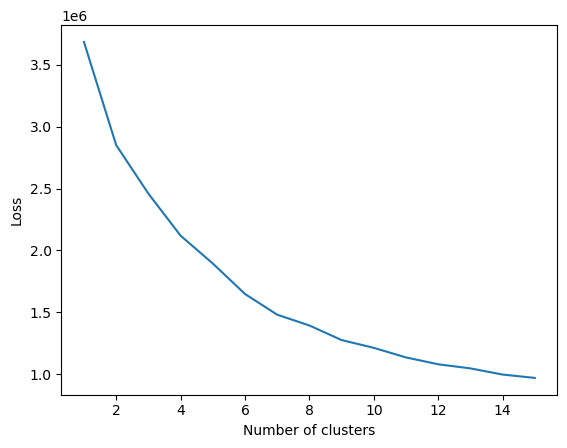

In [11]:
k_optimal(X_scaled_s, 15)

Similar to the complete data set, the subscriber data set shows the same range of optimal clusters from around 6-8.

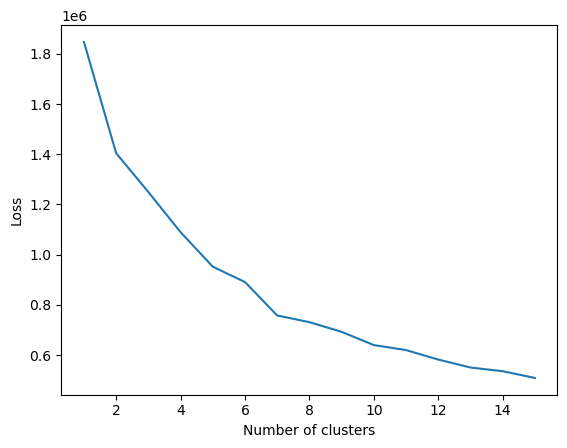

In [12]:
k_optimal(X_scaled_c, 15)

Similar to the complete data set, the customer data set shows the same range of optimal clusters from around 6-8.

### Clustering of user/trip types

##### Clsutering results of complete dataset

In [13]:
# refit algorithm full data

means = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means.fit(X_scaled)

numbers = ['Long distance\ntrips', 'Back home trips\nmid week', 'Work/Uni trips\nstart week', 'Back home trips\nstart week', 'Work/Uni trips\nmid week', 'Day trips\nweekend', 'Going out trips \nmid week/weekend']
#add cluster lables to the dataset
trip_types_scaled["cluster"] = means.predict(X_scaled)
trip_types_scaled["cluster"] = trip_types_scaled["cluster"].apply(lambda x: numbers[x])

trip_types_scaled["month"] = trip_types.month
trip_types_scaled["hour"] = trip_types.hour
trip_types_scaled["weekday"] = trip_types.weekday
trip_types_scaled['duration'] = trip_types.duration_in_hours
trip_types_scaled['user_type'] = trip_types.user_type
trip_types_scaled['season'] = trip_types.season


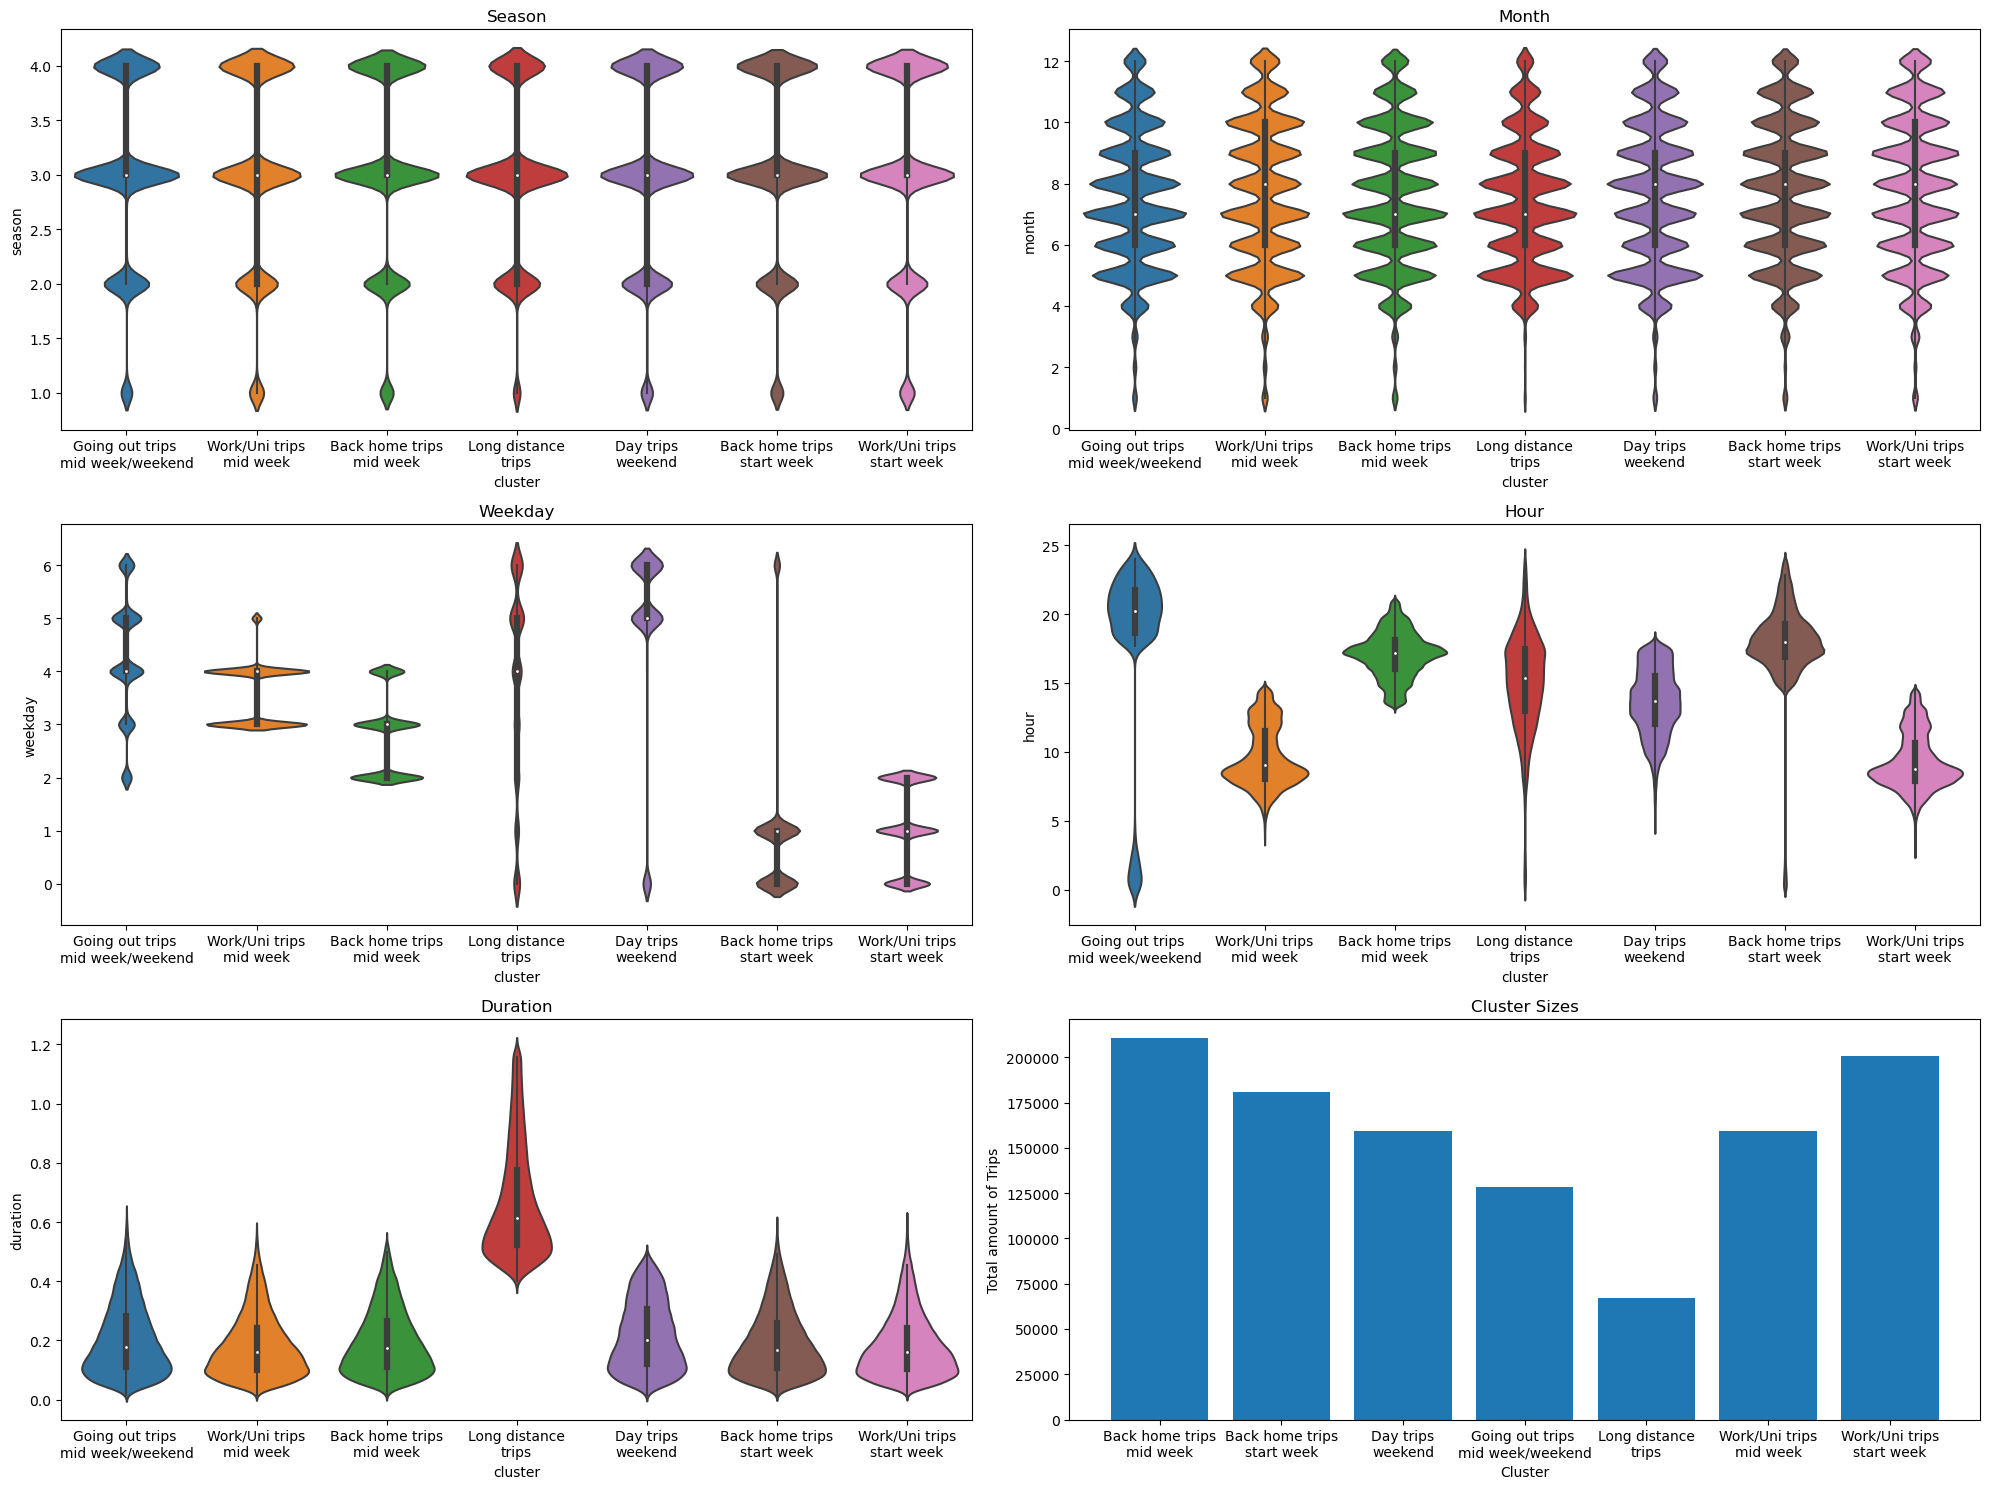

In [14]:

violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x= trip_types_scaled['cluster'], y=trip_types_scaled['season'], data=trip_types_scaled)
sns.violinplot(ax = axes[0, 1], x=trip_types_scaled['cluster'], y=trip_types_scaled['month'], data=trip_types_scaled)
sns.violinplot(ax = axes[1, 0], x=trip_types_scaled['cluster'], y=trip_types_scaled['weekday'], data=trip_types_scaled)
sns.violinplot(ax = axes[1, 1], x=trip_types_scaled['cluster'], y=trip_types_scaled['hour'], data=trip_types_scaled)
sns.violinplot(ax = axes[2, 0], x=trip_types_scaled['cluster'], y=trip_types_scaled['duration'], data=trip_types_scaled)
cluster_size = trip_types_scaled.groupby(['cluster'])['cluster'].agg('count')
axes[2, 1].bar(cluster_size.index, cluster_size)

axes[0, 0].set_title('Season'), axes[0, 1].set_title('Month'), axes[1, 0].set_title('Weekday'), axes[1, 1].set_title('Hour')
axes[2, 0].set_title('Duration'), axes[2, 1].set_xlabel('Cluster'), axes[2, 1].set_ylabel('Total amount of Trips'), axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()


Insights: 

At the start of the week (monday, tuesday, wednesday) people use bikes to get to work/university in the morning , during lunch break and when getting back home. The same applies to end of the week but the cluster in the morning is smaller at this time of the week, which could be explained by people choosing to work in their homeoffices at the end of the week or starting their weekend early. 
Additionally, there are smaller groups that choose to do day trips during the weekend, go out on fridays and saturdays or do long distance trips throughout the week. 

The largest clusters are the ones that use the bikes in the morning hours and the afternoon hours (getting to job/uni and getting back home), which implies that the most usage comes from rides that happen on a regular basis. 

##### Clustering results of subscriber data

In [15]:
# refit algorithm subsriber data

means_s = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means_s.fit(X_scaled_s)

numbers_s = ['Long distance\ntrips', 'Back home trips\nmid week', 'Work/Uni trips\nstart week', 'Back home trips\nstart week', 'Work/Uni trips\nmid week', 'Day trips\nweekend', 'Going out trips \nweekend']


#add cluster lables to the dataset
trip_types_scaled_s["cluster"] = means_s.predict(X_scaled_s)
trip_types_scaled_s["cluster"] = trip_types_scaled_s["cluster"].apply(lambda x: numbers_s[x])

trip_types_scaled_s["month"] = trip_types.month
trip_types_scaled_s["hour"] = trip_types.hour
trip_types_scaled_s["weekday"] = trip_types.weekday
trip_types_scaled_s['duration'] = trip_types.duration_in_hours
trip_types_scaled_s['user_type'] = trip_types.user_type
trip_types_scaled_s['season'] = trip_types.season


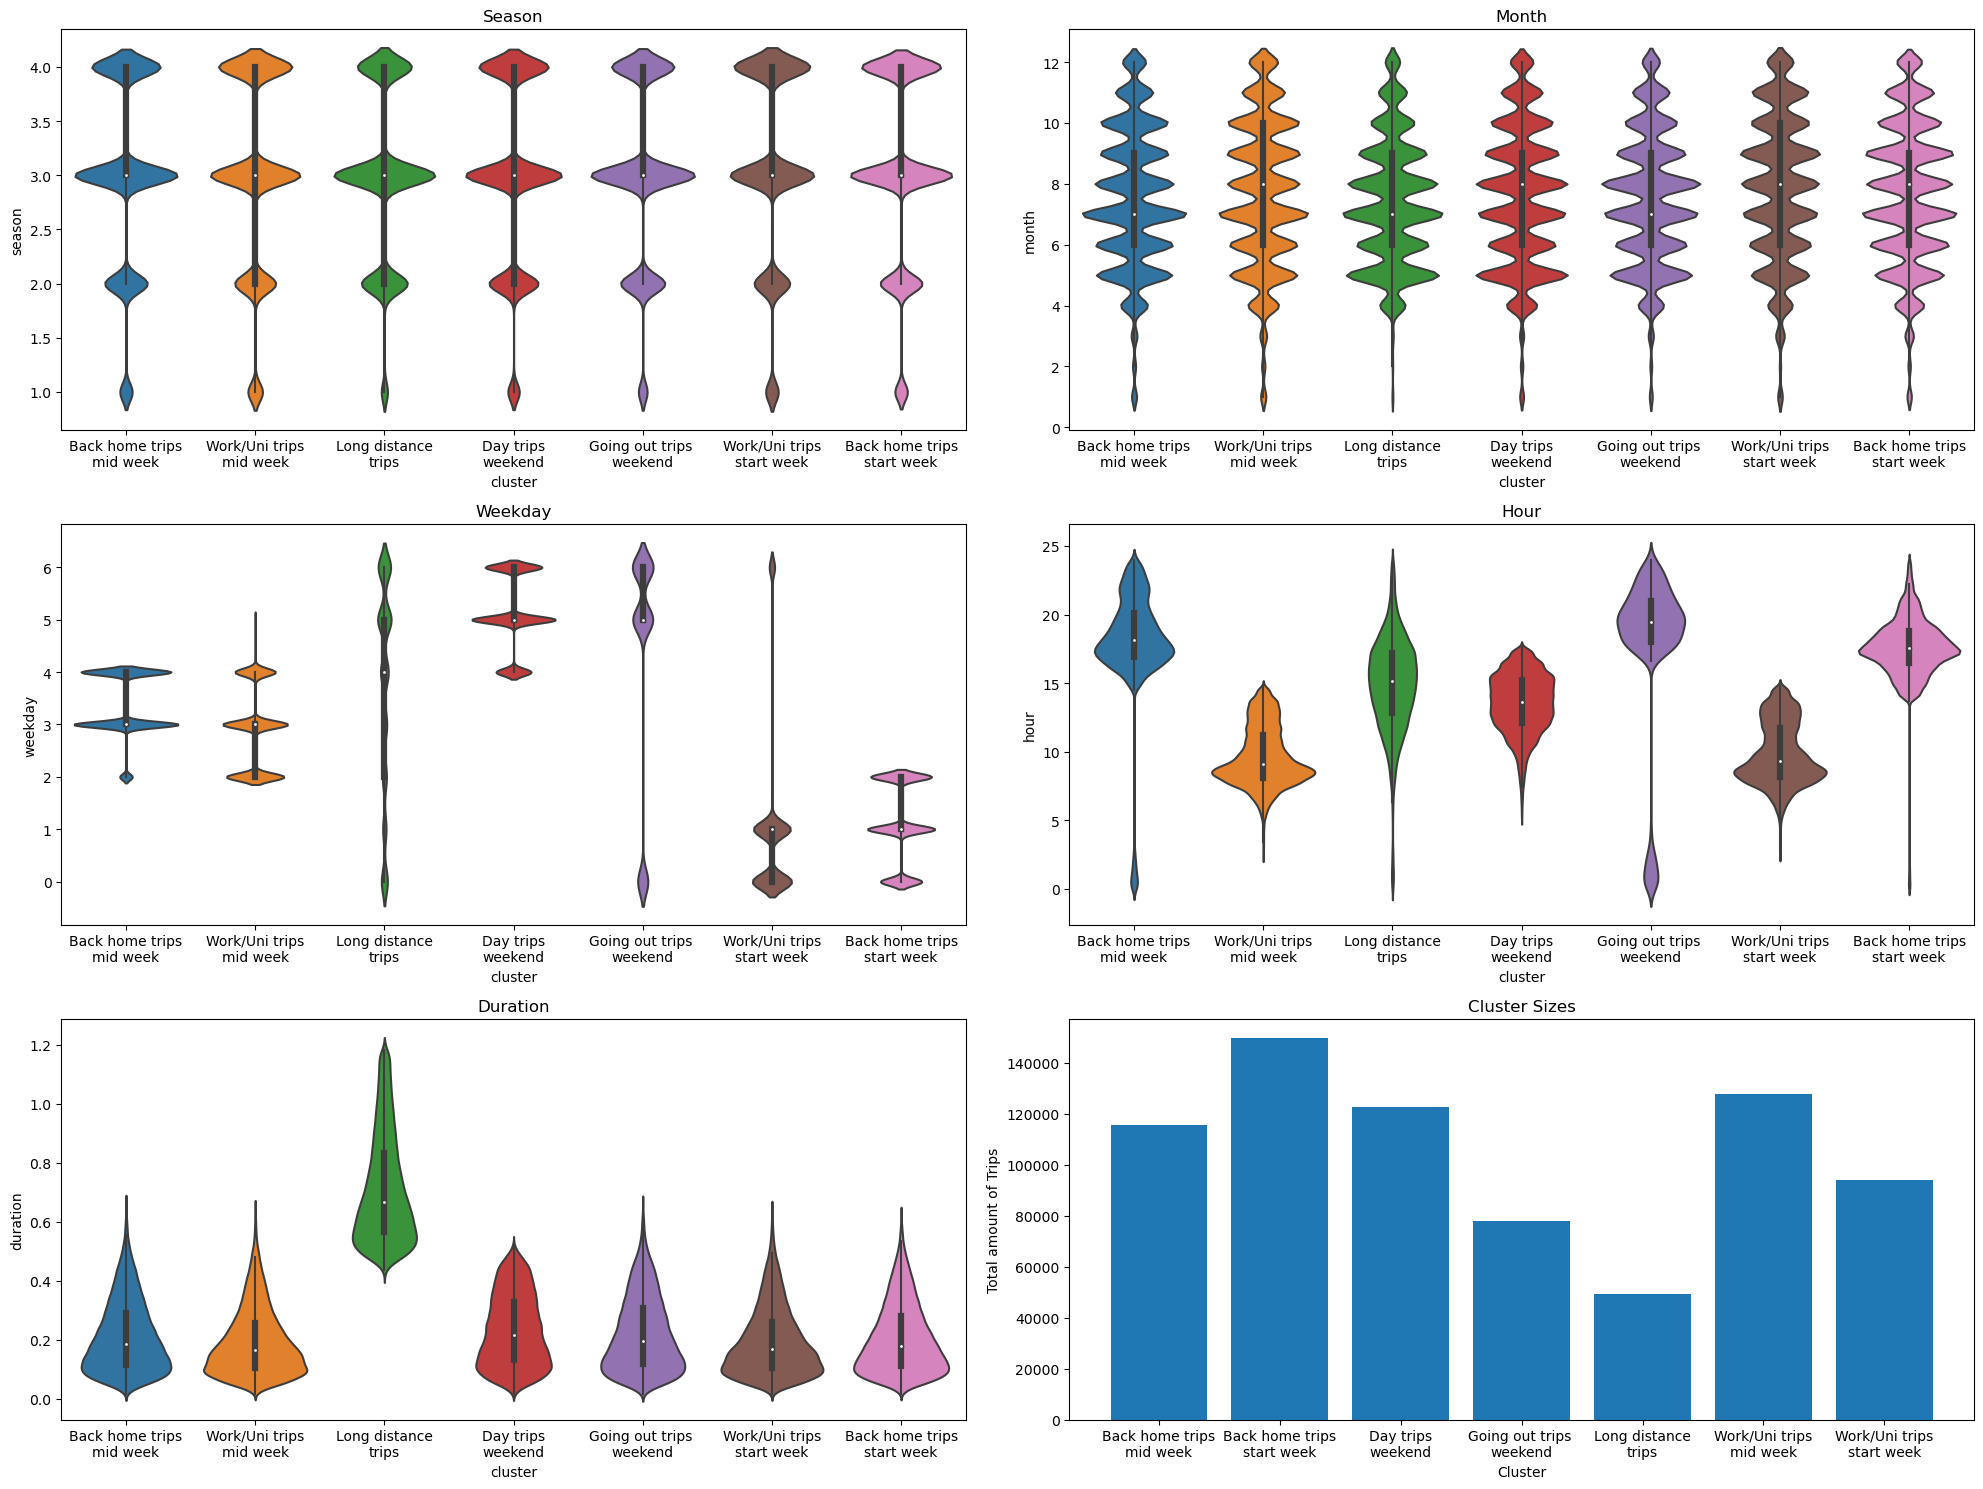

In [16]:
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=trip_types_scaled_s['cluster'], y=trip_types_scaled_s['season'], data=trip_types_scaled_s)
sns.violinplot(ax = axes[0, 1], x=trip_types_scaled_s['cluster'], y=trip_types_scaled_s['month'], data=trip_types_scaled_s)
sns.violinplot(ax = axes[1, 0], x=trip_types_scaled_s['cluster'], y=trip_types_scaled_s['weekday'], data=trip_types_scaled_s)
sns.violinplot(ax = axes[1, 1], x=trip_types_scaled_s['cluster'], y=trip_types_scaled_s['hour'], data=trip_types_scaled_s)
sns.violinplot(ax = axes[2, 0], x=trip_types_scaled_s['cluster'], y=trip_types_scaled_s['duration'], data=trip_types_scaled_s)
cluster_size = trip_types_scaled_s.groupby(['cluster'])['cluster'].agg('count')
axes[2, 1].bar(cluster_size.index, cluster_size)

axes[0, 0].set_title('Season'), axes[0, 1].set_title('Month'), axes[1, 0].set_title('Weekday'), axes[1, 1].set_title('Hour')
axes[2, 0].set_title('Duration'), axes[2, 1].set_xlabel('Cluster'), axes[2, 1].set_ylabel('Total amount of Trips'), axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

Here we got the same tendencies as in the whole dataset. However, subscribers seem to use the bikes also on the weekend during the day and not mainly for work/university trips. 

With the imformation gathered from the geographical demand analysis we know that lots of subscribers tend to study or work at the universities. This piece of information might explain the smaller amount of users driving in the morning ours at the start of the week, student tend to follow different lifestyles and don't neccessarily have to attend courses or work in the beginning of the week. 

##### Clustering results of customer data

In [17]:
# refit algorithm customer data

means_c = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means_c.fit(X_scaled_c)

numbers_c = ['Going out trips \nmid week/weekend', 'Back home trips\nmid week', 'Work/Uni trips\nstart week', 'Day trips\nweekend', 'Back home trips\nstart week', 'Long distance\ntrips', 'Work/Uni trips\nmid week']

#add cluster lables to the dataset
trip_types_scaled_c["cluster"] = means_c.predict(X_scaled_c)
trip_types_scaled_c["cluster"] = trip_types_scaled_c["cluster"].apply(lambda x: numbers_c[x])

trip_types_scaled_c["month"] = trip_types.month
trip_types_scaled_c["hour"] = trip_types.hour
trip_types_scaled_c["weekday"] = trip_types.weekday
trip_types_scaled_c['duration'] = trip_types.duration_in_hours
trip_types_scaled_c['user_type'] = trip_types.user_type
trip_types_scaled_c['season'] = trip_types.season


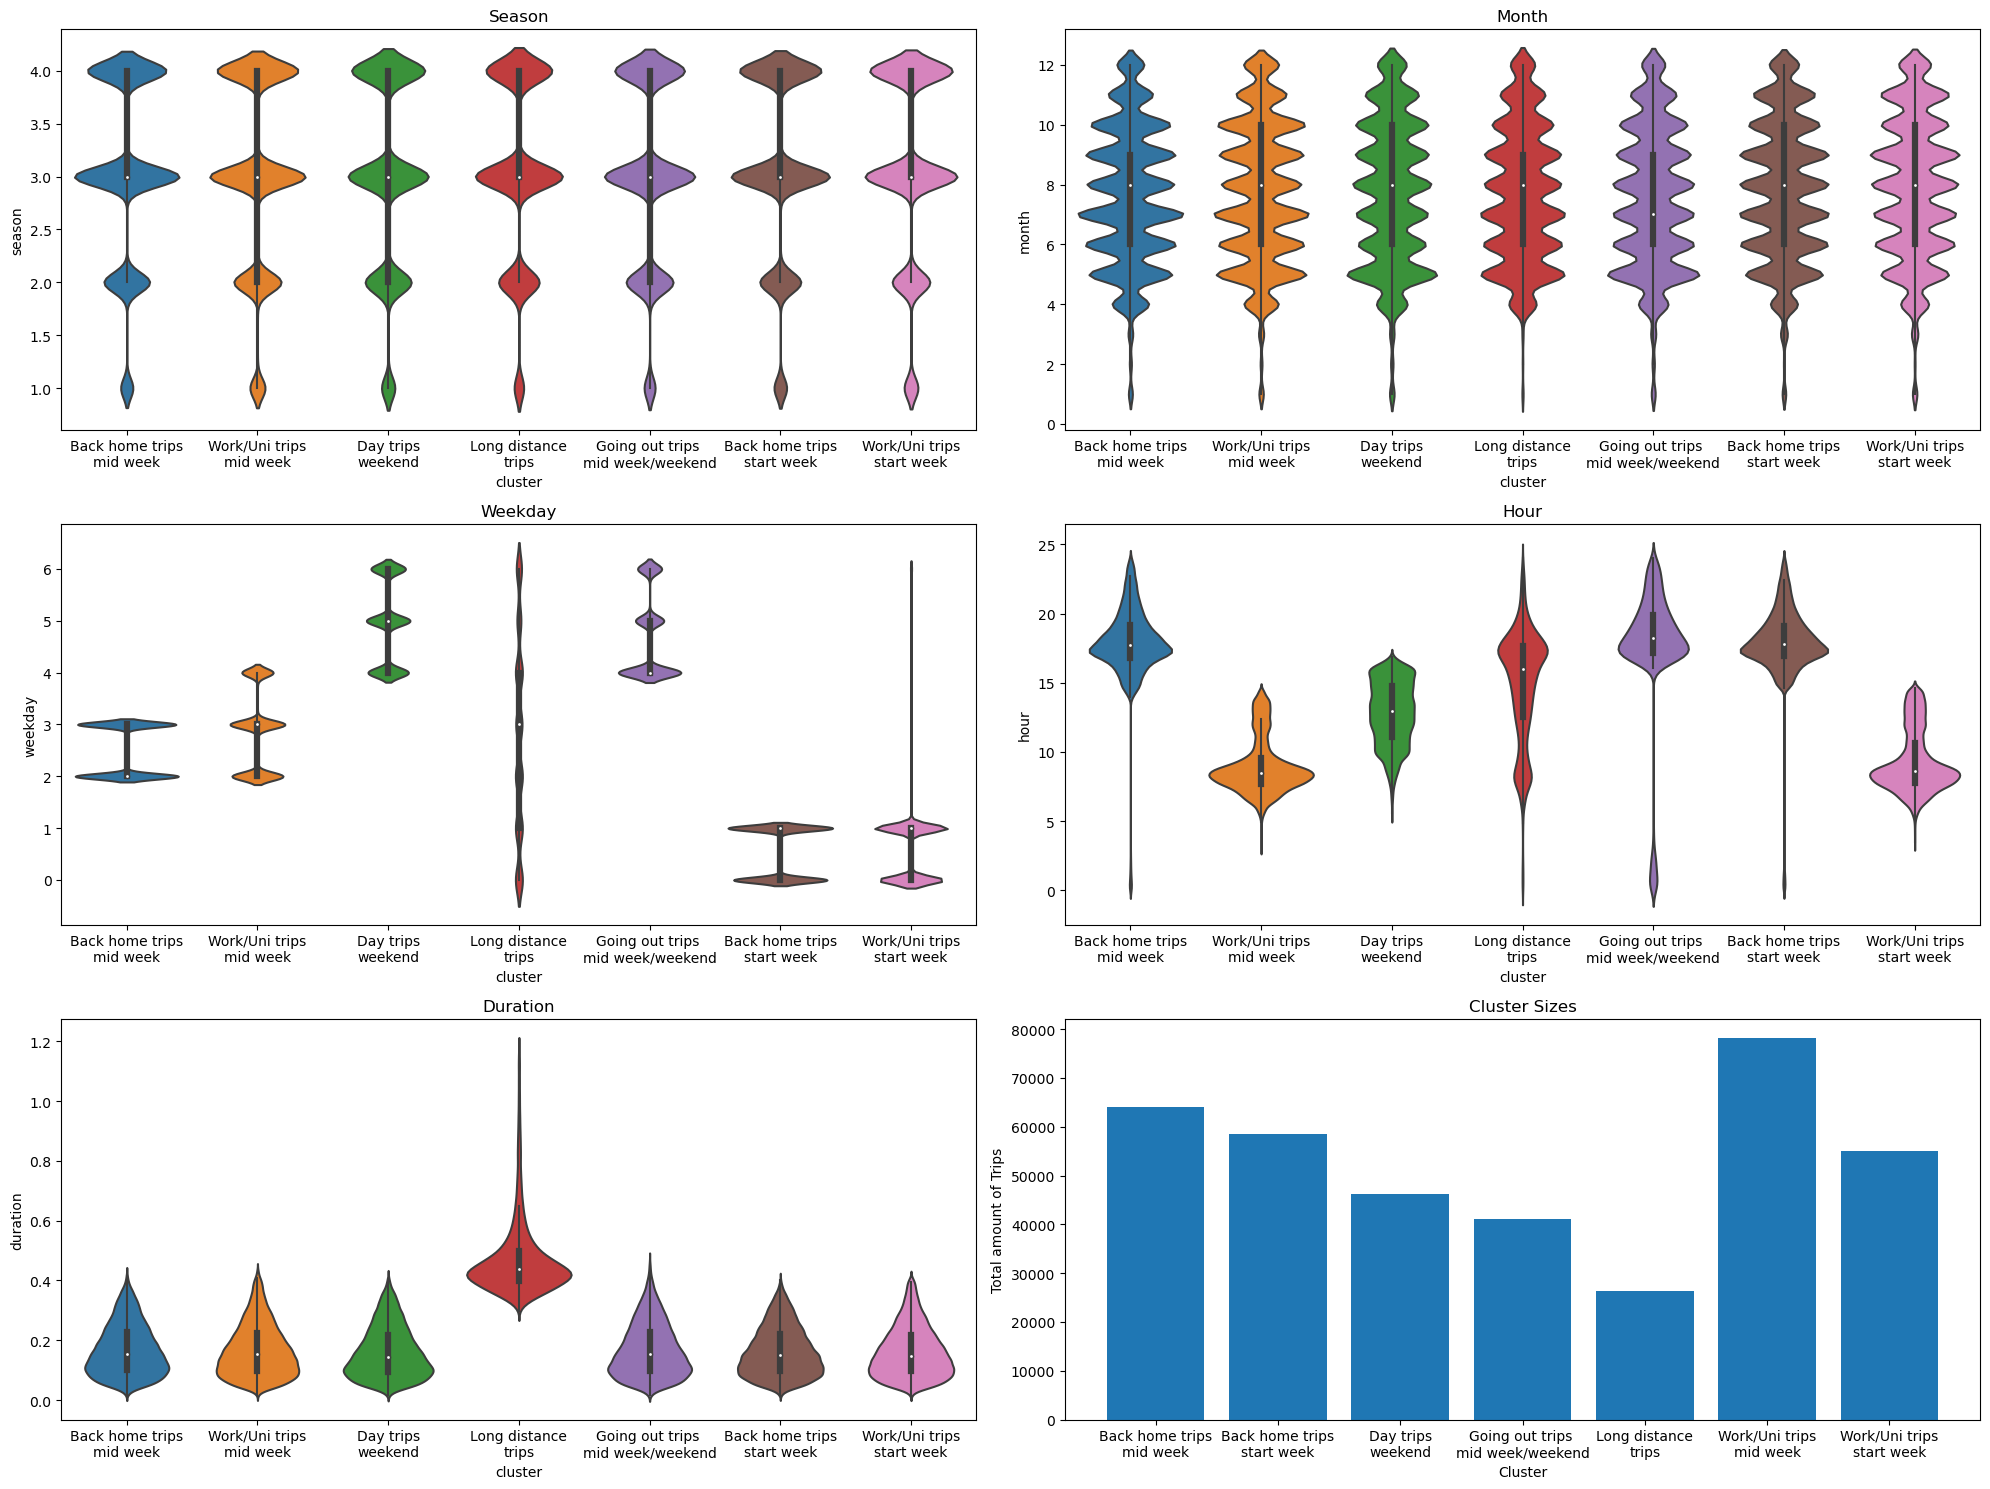

In [18]:
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=trip_types_scaled_c['cluster'], y=trip_types_scaled_c['season'], data=trip_types_scaled_c)
sns.violinplot(ax = axes[0, 1], x=trip_types_scaled_c['cluster'], y=trip_types_scaled_c['month'], data=trip_types_scaled_c)
sns.violinplot(ax = axes[1, 0], x=trip_types_scaled_c['cluster'], y=trip_types_scaled_c['weekday'], data=trip_types_scaled_c)
sns.violinplot(ax = axes[1, 1], x=trip_types_scaled_c['cluster'], y=trip_types_scaled_c['hour'], data=trip_types_scaled_c)
sns.violinplot(ax = axes[2, 0], x=trip_types_scaled_c['cluster'], y=trip_types_scaled_c['duration'], data=trip_types_scaled_c)
cluster_size = trip_types_scaled_c.groupby(['cluster'])['cluster'].agg('count')
axes[2, 1].bar(cluster_size.index, cluster_size)

axes[0, 0].set_title('Season'), axes[0, 1].set_title('Month'), axes[1, 0].set_title('Weekday'), axes[1, 1].set_title('Hour')
axes[2, 0].set_title('Duration'), axes[2, 1].set_xlabel('Cluster'), axes[2, 1].set_ylabel('Total amount of Trips'), axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

The customer group trips are generally shorter but still show similar tendencies than the complete dataset and the subscribers. Thhe biggest groups are again the ones when people drive to or back from work/uni. Nevertheless, the amount of weekend day trips is immensely smaller than in the subscriber's case. By using information from the geographical demand patterns, we know that customers mainly use bike stations in the down town area near major train stations. This beahvior could be a result of people commuting during the week when they have to work but are not in town during the weekend. 

## Clustering locations based on their demand patterns 

In [19]:
#prepare dataframe 
df_preparation = df_boston[['start_station_id', "start_time"]].copy()
df_preparation.loc[:,'hour'] = df_preparation['start_time'].apply( lambda x: x.hour + (x.minute/60))
df_preparation.loc[:,"hour"] = df_preparation['hour'].apply(lambda x: np.trunc(x))
df_preparation.loc[:,'weekday'] = df_preparation['start_time'].apply(lambda x: x.day_of_week)
df_preparation = df_preparation.drop(['start_time'], axis = 1)
df_preparation = df_preparation[df_preparation['weekday'] < 5] 
#filter for weekdays not days on weekend so that the demand during the week gets not biased by weekend usage


In [20]:
#create dataframe with counts for trips at stations at each hour of the day and unstack to get full table
df_stations = df_preparation.groupby(['hour', 'start_station_id']).size().unstack()
df_stations = df_stations.fillna(0) #fill NaN entrys with 0
df_stations.head()

start_station_id,1,3,4,5,6,7,8,9,10,11,...,169,170,171,174,175,176,177,178,179,180
hour,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,26.0,37.0,46.0,32.0,10.0,31.0,47.0,53.0,28.0,...,0.0,0.0,2.0,0.0,4.0,1.0,2.0,16.0,3.0,1.0
1.0,0.0,10.0,31.0,18.0,26.0,0.0,11.0,28.0,22.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0
2.0,0.0,12.0,5.0,11.0,3.0,1.0,5.0,13.0,8.0,6.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,6.0,2.0,0.0
3.0,0.0,3.0,0.0,4.0,3.0,0.0,1.0,7.0,4.0,5.0,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0
4.0,0.0,4.0,3.0,1.0,4.0,1.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0


In [21]:
#scale dataframe to avoid different weight caused by skewed data
stations_scaled, df_stations_scaled= scaling(df_stations)

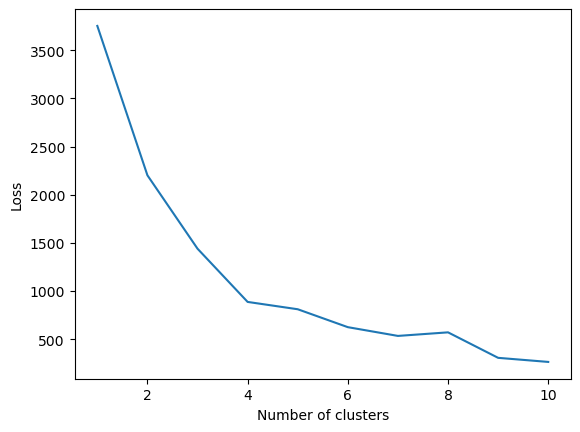

In [22]:
#calculate optimal amount of clusters
k_optimal(stations_scaled, 10)

3-5 Cluster seem to be the reasonable spectrum. After further research K = 3 gave the most insightful results

In [23]:
#transpose data to apply k means method with hours as x axis and stations as y axis
stations_scaled_trans = stations_scaled.transpose()
df_stations_scaled_trans = df_stations_scaled.transpose()

In [30]:
#apply k means method
means_stations = MiniBatchKMeans(n_clusters=3, random_state=42,init="k-means++")
means_stations.fit(stations_scaled_trans)

numbers_stations = ['Living Area', 'Mixed Area', 'Working/University Area']

#add cluster lables to the dataset
df_stations_scaled_trans["cluster"] = means_stations.predict(stations_scaled_trans)
df_stations_scaled_trans["cluster"] = df_stations_scaled_trans["cluster"].apply(lambda x: numbers_stations[x])

In [31]:
#sort stations into respective cluster dataframes
df_stations_one = df_stations_scaled_trans.loc[df_stations_scaled_trans['cluster'] == 'Living Area']
df_stations_two = df_stations_scaled_trans.loc[df_stations_scaled_trans['cluster'] == 'Mixed Area']
df_stations_three = df_stations_scaled_trans.loc[df_stations_scaled_trans['cluster'] == 'Working/University Area']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)


(None,
 Text(0.5, 1.0, 'Cluster 3: Work/University\nArea'),
 Text(150.09722222222223, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

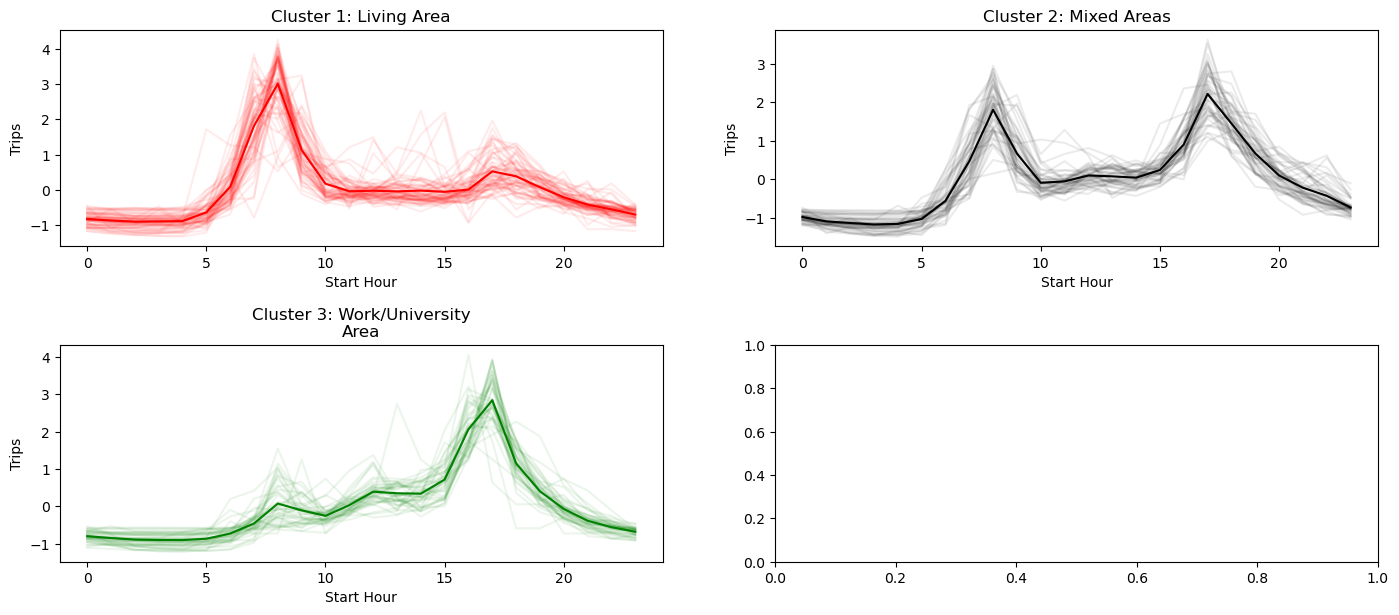

In [33]:
#plot the results
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: Living Area'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='black', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='black', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: Mixed Areas'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: Work/University\nArea'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')


The first cluster peaks in the morning which implies that people rent bikes at these start stations to get to work/university from their living area. The opposite applies  for cluster three where the demand peaks in the afternoon when people drive back from their working or university areas to get back home. Cluster three shows mixed areas where people live and work and attend university.

In [34]:
#prepare data for mapping by adding location features again
mapping = df_stations_scaled_trans['cluster'].copy()
df_mapping = pd.DataFrame(mapping)
df_mapping['station_id'] = df_mapping.index
df_mapping = df_mapping.reset_index(drop = True)

df_dummy = df_boston[['start_station_latitude', 'start_station_longitude', 'start_station_id']]
df_dummy  = df_dummy.rename(columns = {'start_station_id': 'station_id'})
output_map = pd.merge(df_dummy, df_mapping, on = 'station_id')
output_map = output_map.drop_duplicates()
output_map = output_map.reset_index()
output_map = output_map.drop(['index'], axis = 1)
output_map

,start_station_latitude,start_station_longitude,station_id,cluster
0,42.387995,-71.119084,115,Living Area
1,42.361962,-71.092053,80,Working/University Area
2,42.366277,-71.091690,91,Working/University Area
3,42.356954,-71.113687,105,Living Area
4,42.374035,-71.101427,88,Living Area
...,...,...,...,...
151,42.359573,-71.101295,178,Mixed Area
152,42.362648,-71.100061,177,Working/University Area
153,42.355601,-71.103945,179,Mixed Area
154,42.386748,-71.119019,176,Living Area


In [37]:
#splitting data in order to assign different colors on map for each cluster
output_one = output_map.loc[output_map['cluster'] == 'Living Area']
output_two = output_map.loc[output_map['cluster'] == 'Mixed Area']
output_three = output_map.loc[output_map['cluster'] == 'Working/University Area']

#center coordinates for map
avg_lat = output_map['start_station_latitude'].mean()
avg_long = output_map['start_station_longitude'].mean()
center = [avg_lat, avg_long]

In [38]:
#map clusters
map = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=14, 
        control_scale=True, 
        max_zoom=20)

for index, row in output_one.iterrows():
        folium.CircleMarker(
            radius=5,
            location=[row['start_station_latitude'],row['start_station_longitude']], 
            popup = (row['station_id'], row['cluster']),
            alpha=0.2,
            color = 'crimson',
            fill_color='crimson'
        ).add_to(map)

for index, row in output_three.iterrows():
        folium.CircleMarker(
            radius=5,
            location=[row['start_station_latitude'],row['start_station_longitude']], 
            popup = (row['station_id'], row['cluster']),
            alpha=0.2,
            color = 'green',
            fill_color='green'
        ).add_to(map)

for index, row in output_two.iterrows():
        folium.CircleMarker(
            radius=5,
            location=[row['start_station_latitude'],row['start_station_longitude']], 
            popup = (row['station_id'], row['cluster']),
            alpha=0.2,
            color = 'black',
            fill_color='black'
        ).add_to(map)

map

The results show,  that stations clustered in the living area are on average further away form the city center which is where living areas are generally located. 
Furthermore, stations of the work area are located near the city center, the universities, and down town.
Stations in the mixed area are located closer to city center but occasionally (north west) also a little further away.